#Noise Model and Optimization

This notebook implements `quantum noise simulation` and `circuit optimization`—crucial extensions for advancing the reliability and performance of the Galton board circuit. By introducing realistic noise models, such as decoherence and gate errors, each operation is subjected to the `stochastic disturbances` found in real quantum hardware. Optimization routines systematically tune gate parameters, sequence arrangements, and error mitigation techniques in response to these noise effects, allowing the circuit to retain fidelity and statistical accuracy across various noisy environments. This dual approach of noise emulation and refinement, equips the quantum Galton board to accurately simulate real-world quantum behavior, facilitating robust studies of both ideal and imperfect statistical processes.

## Setup and Installation

To run the quantum circuit simulation and related analyses in this notebook, ensure you have the required `Python packages` installed.

In [1]:
!pip install qiskit qiskit-aer qiskit_ibm_runtime numpy scipy matplotlib pylatexenc

In [2]:
import time
import collections
import pylatexenc
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

##Functions

###Quantum Walk Step: One Peg Galton Board

In [3]:
def one_peg_galton_board(
    qc: QuantumCircuit,
    control_qubit: QuantumRegister,
    target_q_reg: QuantumRegister,
    center_idx: int,
    j: int,
    is_last_step: bool
):
    """
    Applies one step of the controlled-swaps sequence which illustrates one peg in a certain level forms the core of the
    quantum wala. This function encapsulates the four-gate sequence

    Args:
        qc: The QuantumCircuit to add gates to.
        control_qubit: The qubit controlling the operations.
        target_q_reg: The register on which the walk occurs.
        center_idx: The index of the center qubit in target_q_reg.
        j: The offset from the center for the current step.
        is_last_step: A boolean to prevent adding a final CNOT.
    """
    # Define the three qubits involved in this step
    qubit_A = target_q_reg[center_idx + j - 1]
    qubit_B = target_q_reg[center_idx + j]
    qubit_C = target_q_reg[center_idx + j + 1]

    # The Quantum circuit for 1 peg step
    qc.cswap(control_qubit, qubit_A, qubit_B)
    qc.cx(qubit_B, control_qubit)
    qc.cswap(control_qubit, qubit_B, qubit_C)

    # The final CNOT is omitted on the last step of the inner loop for optimization purpose
    if not is_last_step:
        qc.cx(qubit_C, control_qubit)

###Galton Board Circuit

In [4]:
def Galton_board_circuit(level: int,Controls : list=None) -> QuantumCircuit:
    """
    Builds the complete quantum galton board circuit in a structured and modular way.

    Args:
        level: No. of levels in Galton board
        Controls: List of value of theta of each level(defalut:It performs hadamard gate)

    Returns:
        The fully constructed Quantum Galton Board Circuit object.
    """
    # If no custom controls are provided, use Hadamard (pi/2 RX) at each level
    if Controls==None:
      Controls=[np.pi/2]*level

    # Check if the number of control angles matches the number of levels
    if len(Controls)!=level:
        raise ValueError("Not optimal Control")

    # 1. SETUP: Define quantum and classical registers
    num_qubits = 2 * (level + 1) # Number of qubits needed for the walk space
    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(level + 1, "c")
    circuit = QuantumCircuit(q, c) # Create the quantum circuit

    # Define key qubit indices
    control_qubit = q[0]
    center_qubit_index = level + 1 # This is the starting position index

    # 2. INITIAL STATE: Prepare the system
    '''Set the qubit at the center_qubit_index to the |1> state.This initializes the walk at the central
      position in the quantum walk space'''

    circuit.x(q[center_qubit_index])

    # 3. ALGORITHM: Build the main logic of the circuit
    for i in range(level):
        circuit.reset(control_qubit)
        circuit.rx(Controls[i],control_qubit)
        indices = list(range(-i, i+1, 2))
        '''Get list of relative position of individual peg circuit relative to center qubit for a particular value of i(level)
           Example:
          - i=0 -> [0]
          - i=1 -> [-1, 1]
          - i=2 -> [-2, 0, 2]
          - i=3 -> [-3,-1,1,3]'''
        # Apply the quantum walk step (one peg operation) for each relevant position in the current level
        for step_index, j in enumerate(indices):
            # Check if this is the last step in the inner loop for optimization
            is_last = (step_index == len(indices) - 1)
            one_peg_galton_board(
                qc=circuit,
                control_qubit=control_qubit,
                target_q_reg=q,
                center_idx=center_qubit_index,
                j=j,
                is_last_step=is_last
            )
    circuit.barrier()

    # 4. MEASUREMENT: Measure the desired qubits to get the result
    qubits_to_measure = [q[i] for i in range(num_qubits) if i % 2 != 0]
    circuit.measure(qubits_to_measure, c) # Measure the selected qubits into the classical register

    return circuit

###Finding $θ_j$ For a Target Distribution

In [5]:
def find_theta_values(target_probs):
    """
    Find theta values for each peg so that the resulting distribution matches
    a given target probability distribution.

    Parameters:
        target_probs: Target probability distribution for k=0,...,levels right turns.
    Returns:
        list of float: Optimal theta values in radians.
    """
    target_probs = np.array(target_probs, dtype=float)
    target_probs /= target_probs.sum()  # Normalize

    levels = len(target_probs) - 1  # circuit_level

    # Each peg's right probability: p_j = cos^2(theta_j / 2)

    def computed_distribution(thetas):
        p = np.cos(np.array(thetas) / 2) ** 2
        dist = np.array([1.0])
        for prob in p:
            dist = np.convolve(dist, [1 - prob, prob])
        return np.sum((dist - target_probs) ** 2)

    # Initial guess & bounds
    initial = np.full(levels, np.pi / 2)
    bounds = [(0, np.pi) for _ in range(levels)]

    # Optimize
    result = minimize(computed_distribution, initial, bounds=bounds, method='L-BFGS-B')

    if result.success:
        return result.x.tolist()
    else:
        raise RuntimeError("Optimization failed to converge")


##Noise Model


### IBM Quantum API Setup with QiskitRuntimeService

This setup uses your **IBM Quantum API token**—retrievable from your account dashboard—to securely connect to the correct platform environment with `QiskitRuntimeService`.

By designating options like `channel` and `instance`, you target your preferred workspace.

Selecting `"ibm_torino"` as the backend gives you access to one of several real quantum devices available for free, perfect for both learning and experimentation.

The **noise model**, drawn directly from the backend’s current calibration data:

- Captures the machine’s actual error characteristics.
- Allows your simulations to realistically mirror the behavior you’d expect from genuine quantum hardware.

With these elements working together, you’re well-equipped to benchmark and refine algorithms in both ideal and practical scenarios.


In [6]:
Service = QiskitRuntimeService(token='0uXPRBWEy7Xx9LgbO04uJr5VcGa-pt4xd0846FYJQJgf',
                               channel='ibm_quantum_platform',
                               instance='Wiser monte carlo')
Backend = Service.backend("ibm_torino")
noise_model = NoiseModel.from_backend(Backend)

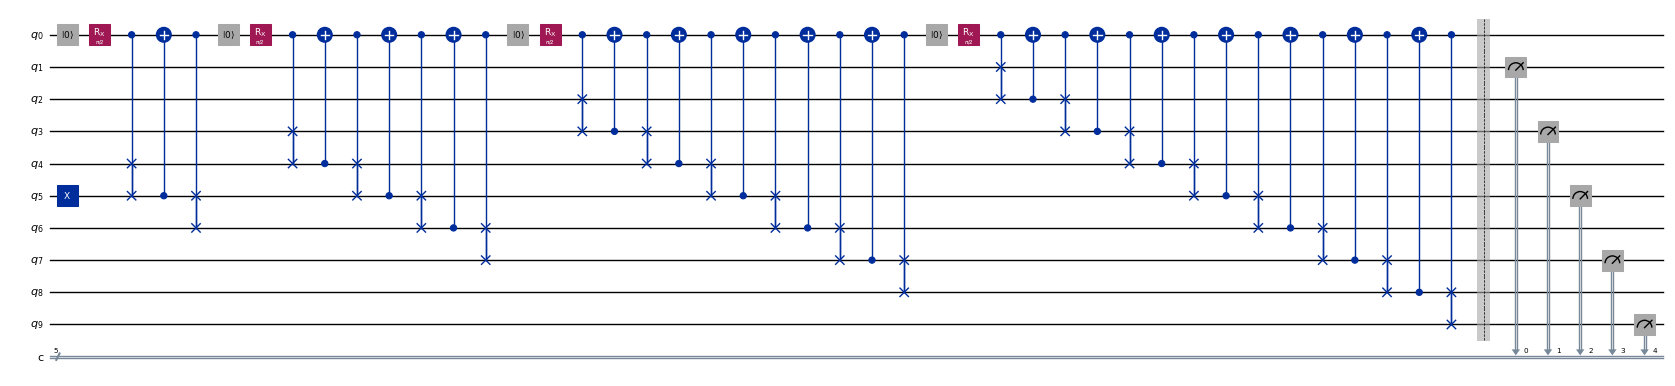

In [7]:
# Set the level for the circuit
circuit_level = 4

# Build the circuit
my_circuit = Galton_board_circuit(level=circuit_level)
my_circuit.draw('mpl',scale=0.5,fold=100)

{'01111': 1, '01101': 3, '10011': 2, '11001': 3, '11101': 1, '11000': 12, '01011': 4, '01110': 6, '10100': 10, '01010': 19, '00010': 199, '00000': 81, '10000': 30, '00100': 270, '01100': 29, '10101': 1, '10010': 8, '11100': 5, '00001': 44, '10110': 1, '01000': 171, '00110': 41, '11010': 1, '01001': 15, '00101': 26, '10001': 8, '00111': 1, '00011': 8}


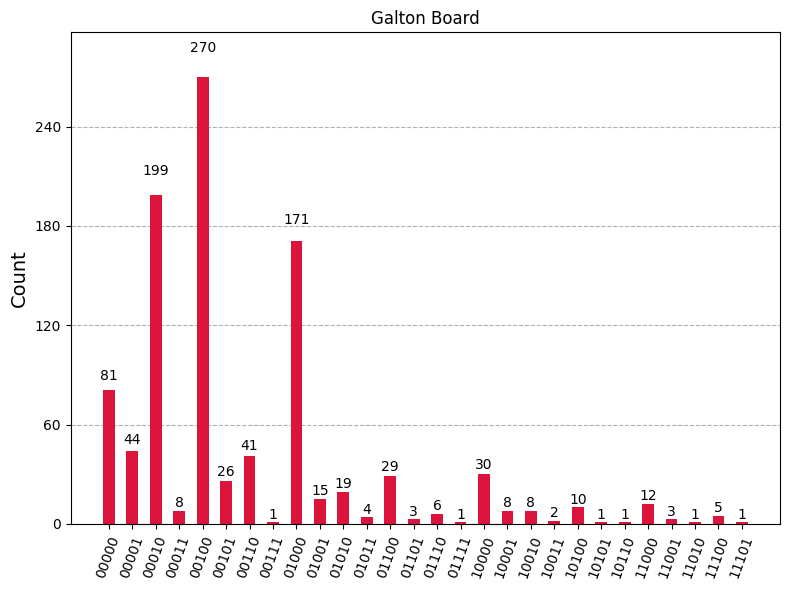

In [8]:
# Transpile for simulator
simulator = AerSimulator(method='density_matrix',noise_model=noise_model)
transpiled = transpile(my_circuit, simulator,optimization_level=None)

# Execute
job = simulator.run(transpiled, shots=1000)
result = job.result()
counts = result.get_counts(0)
print(counts)
plot_histogram(counts, bar_labels=True, color=['crimson'],
                title="Galton Board",figsize=(8,6))

### Graph — Key Observations

#### 1. Peak Outcomes
- The `highest peaks` appear at:
  - 00001
  - 00010
  - 00100
  - 01000
  - 10000
- This is **expected** for a Galton board, as these outcomes represent the most probable paths according to the `binomial distribution`.

#### 2. Unusually High Count for 00000
- Likely caused by `decoherence` or `noise` in the quantum system.
- Quantum states may **collapse** into this state more frequently, `biasing` the expected distribution.
- Mitigation:
  - **Transpiling** the circuit to reduce the number of gates lowers the chance for errors and decoherence.
  - However, **some decoherence is unavoidable** in current quantum hardware.

- As hardware improves and **coherence times** increase, this bias will **reduce** but never be **completely eliminated** due to **intrinsic quantum noise**.


### 3. Asymmetry in Distribution
- more outcomes appear on **one side** (e.g., left-biased):
  - Could indicate **gate operation bias**
  - Or **additional error sources**



Measurement counts (no noise): {'00001': 71, '00010': 230, '10000': 72, '00100': 375, '01000': 252}
Measurement counts (noise): {'00010': 199, '10000': 30, '00100': 270, '00001': 44, '01000': 171}


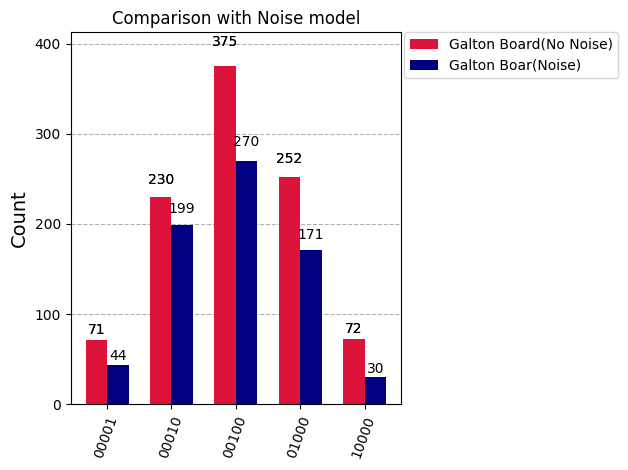

In [9]:
# 2. Execute simulation on the Aer simulator (ideal, noiseless)
sim = AerSimulator(method='matrix_product_state')
result_ = sim.run(my_circuit, shots=1000).result()
counts_ = result_.get_counts()

# 3. Display results as a histogram
print("Measurement counts (no noise):", counts_)

bitstring_to_int = {'0' * (circuit_level - i) + '1' + '0' * i: i for i in range(circuit_level + 1)}
filtered_data = {k: v for k, v in counts.items() if k in bitstring_to_int}
print("Measurement counts (noise):", filtered_data)
plot_histogram(
    [counts_, filtered_data],
    legend=["Galton Board(No Noise)", "Galton Boar(Noise)"],
    color=['crimson', 'navy'],title="Comparison with Noise model"
)

##Optimization

###Qiskit Transpiler

The `Qiskit transpiler` is a key component in the Qiskit quantum computing framework that transforms and `optimizes` quantum circuits for `specific` quantum hardware.
It takes my abstract circuit and:

- Matches it to the Hardware’s `Native gate` set and qubit layout.  
- Decides how to place qubits and adds `SWAPs` if needed.  
- Breaks down `higher-level gates` into the device’s native ones.  
- Tries to keep the circuit as `short` and error-free as possible.

We can choose how aggressive the `optimization` should be(levels 0–3).
This step is key because it enables realistic noise simulation and better execution on noisy, imperfect quantum devices, making it essential for practical quantum computing.

#### Native Gates on ibm_torino (Heron Family)

`CZ`, `RZ`, `SX`, `X`, `ID`, `RESET`, `MEASURE`, `DELAY`, `if_else`, `for_loop`, `switch_case`.

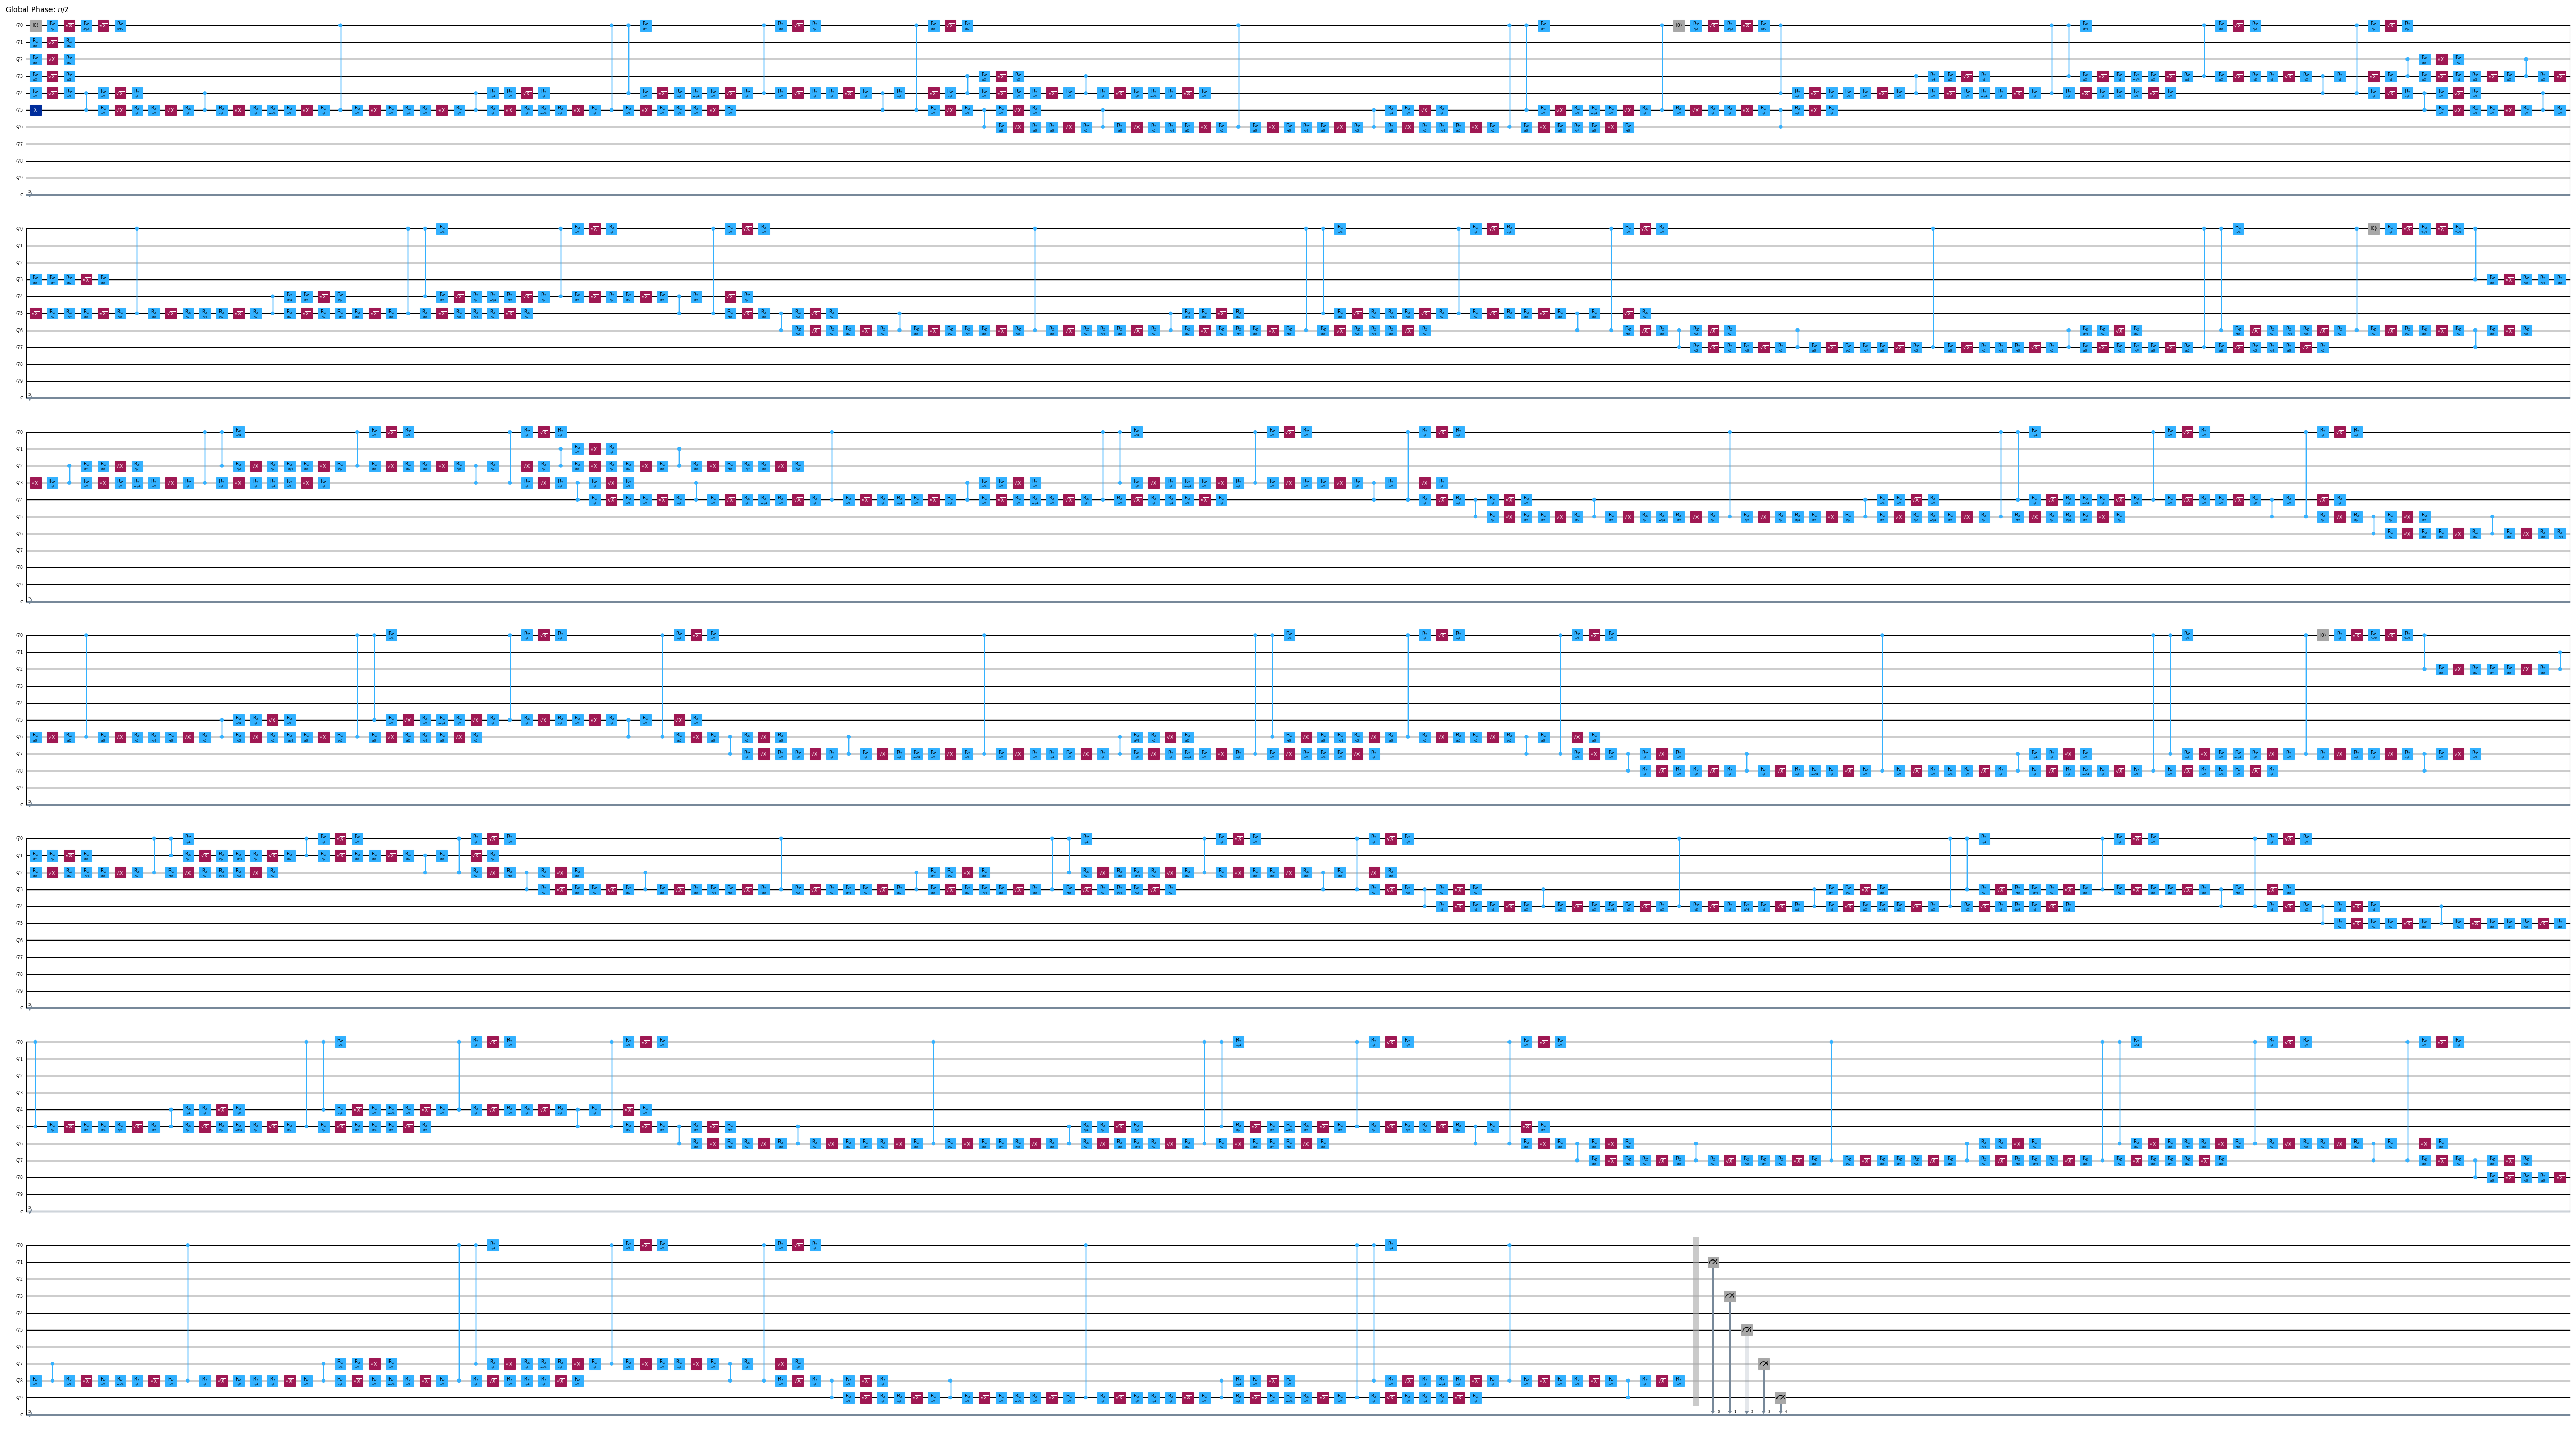

In [10]:
transpiled = transpile(my_circuit, simulator,optimization_level=0)
transpiled.draw('mpl',scale=0.5,fold=150)

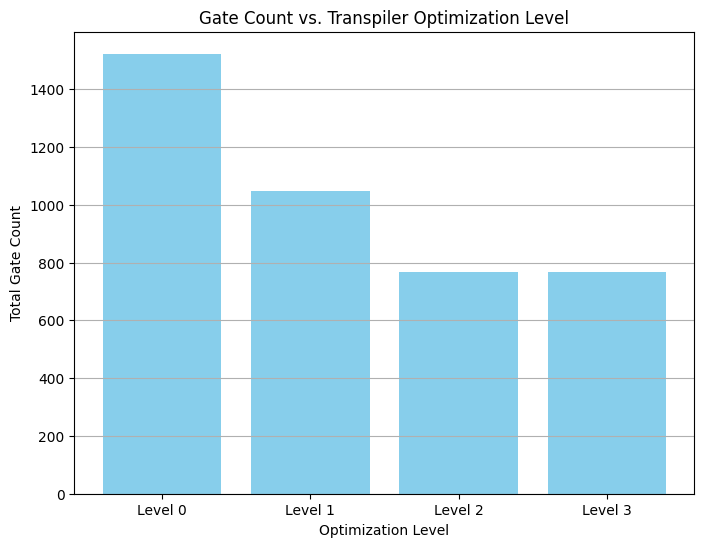

In [11]:
# Define optimization levels to compare
optimization_levels = [0, 1, 2, 3]
gate_counts_by_level = {}

for level in optimization_levels:
    # Transpile the circuit with the current optimization level
    transpiled_circuit = transpile(my_circuit, simulator, optimization_level=level)

    # Get the gate counts
    gate_counts = collections.Counter(transpiled_circuit.count_ops())

    # Store the total number of gates
    total_gates = sum(gate_counts.values())
    gate_counts_by_level[f'Level {level}'] = total_gates

# Prepare data for the histogram
levels = list(gate_counts_by_level.keys())
counts = list(gate_counts_by_level.values())

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(levels, counts, color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Total Gate Count")
plt.title("Gate Count vs. Transpiler Optimization Level")
plt.grid(axis='y')
plt.show()

##Simulation and Visualisation

###Exponential distribution

In [12]:
def exponential_distribution(x:np.ndarray, lambda_:int):
  return lambda_ * np.exp(-lambda_ * x)

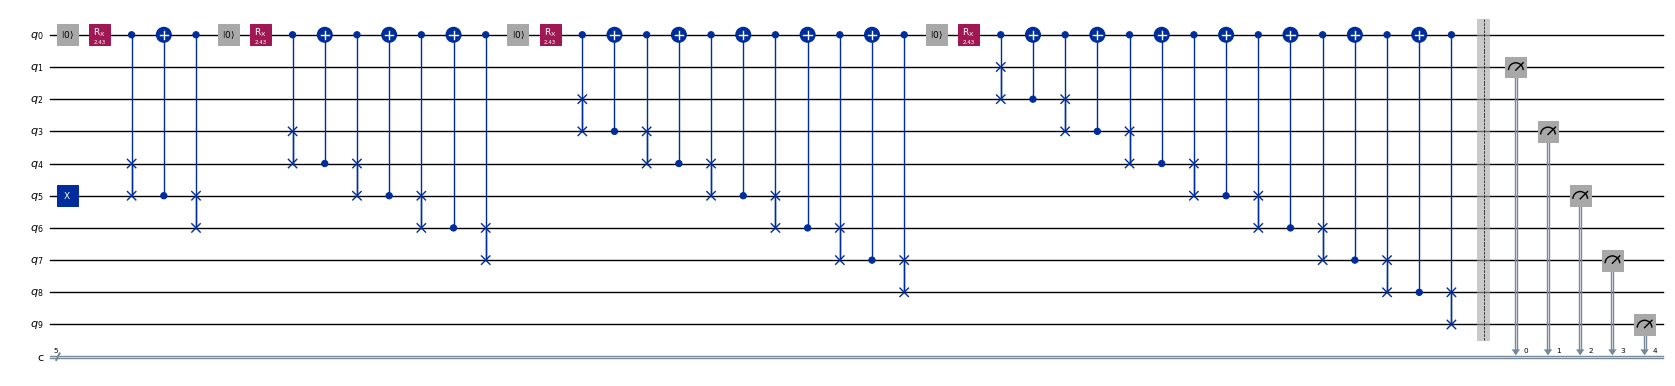

In [22]:
circuit_level = 4
k = np.arange(circuit_level + 1)
lam = 0.82
target_probs = exponential_distribution(k,lam)
circuit_controls= find_theta_values(target_probs)

# Build the circuit
my_circuit = Galton_board_circuit(level=circuit_level,Controls=circuit_controls)
my_circuit.draw('mpl',scale=0.5,fold=100)

Measurement counts (noise): {'10000': 1, '00010': 253, '00100': 53, '01000': 8, '00001': 411}


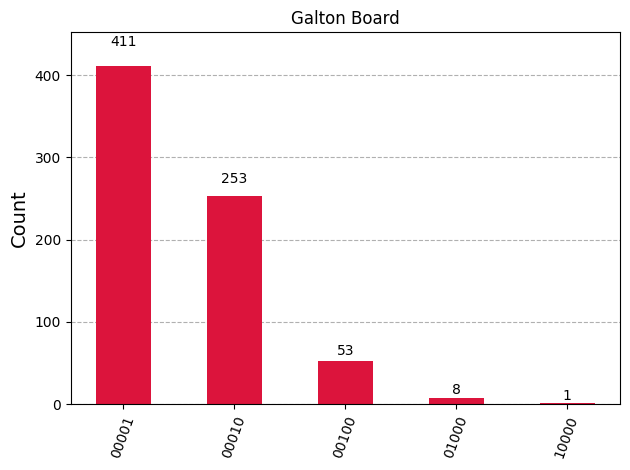

In [23]:
# Transpile for simulator
simulator = AerSimulator(method='density_matrix',noise_model=noise_model)
transpiled = transpile(my_circuit, simulator,optimization_level=3)

# Execute
job = simulator.run(transpiled, shots=1000)
result = job.result()
counts = result.get_counts(0)
bitstring_to_int = {'0' * (circuit_level - i) + '1' + '0' * i: i for i in range(circuit_level + 1)}
filtered_data = {k: v for k, v in counts.items() if k in bitstring_to_int}
print("Measurement counts (noise):", filtered_data)
plot_histogram(filtered_data, bar_labels=True, color=['crimson'],
                title="Galton Board")

###Hadamard quantum walk

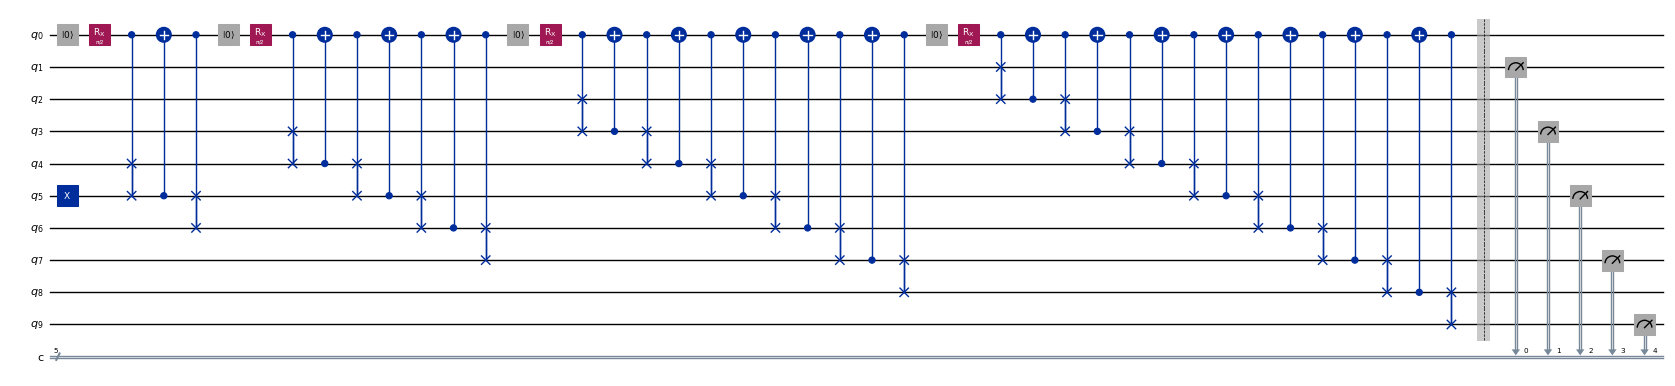

In [15]:
circuit_level = 4
circuit_controls= None #None:needed it is default

# Build the circuit
my_circuit = Galton_board_circuit(level=circuit_level)
my_circuit.draw('mpl',scale=0.5,fold=100)

Measurement counts (noise): {'00010': 165, '00100': 287, '10000': 56, '01000': 162, '00001': 59}


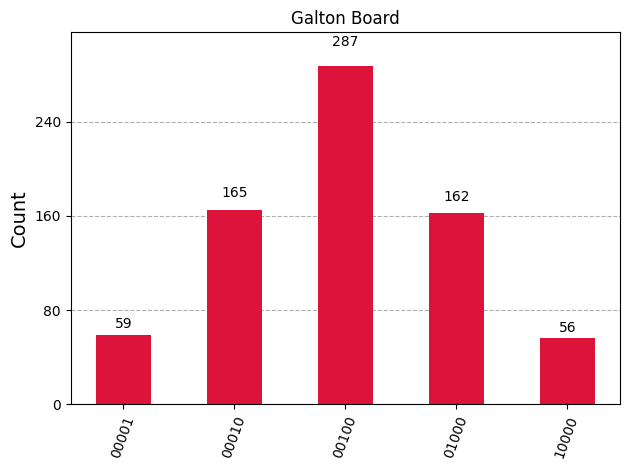

In [16]:
# Transpile for simulator
simulator = AerSimulator(method='density_matrix',noise_model=noise_model)
transpiled = transpile(my_circuit, simulator,optimization_level=3)

# Execute
job = simulator.run(transpiled, shots=1000)
result = job.result()
counts = result.get_counts(0)
bitstring_to_int = {'0' * (circuit_level - i) + '1' + '0' * i: i for i in range(circuit_level + 1)}
filtered_data = {k: v for k, v in counts.items() if k in bitstring_to_int}
print("Measurement counts (noise):", filtered_data)
plot_histogram(filtered_data, bar_labels=True, color=['crimson'],
                title="Galton Board")